<a href="https://colab.research.google.com/github/aksharat/Medical-Projects/blob/main/BME507_PreWarmUp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import the essential libraries
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
# Import the MNIST dataset into local system
from torchvision import datasets
from torchvision.transforms import ToTensor
#Preparing data for training with Dataloaders
from torch.utils.data import DataLoader
#Import swin_t model
from torchvision.models import swin_t
from torchvision.models import Swin_T_Weights

In [ ]:
#Download the training and test data
train_data = datasets.MNIST(root='data',train=True,
                            transform=ToTensor(),download=True)
test_data = datasets.MNIST(root='data',train=False,
                            transform=ToTensor())

100%|██████████| 9912422/9912422 [00:00<00:00, 94954667.47it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 32989023.37it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 25210484.59it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 5981327.71it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



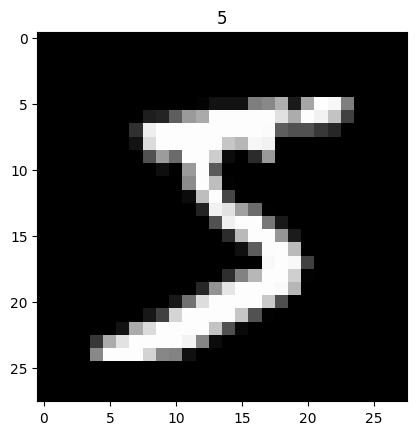

In [ ]:
#Visualize one sample data
plt.imshow(train_data.data[0],cmap = 'gray')
plt.title('%i'%train_data.targets[0])
plt.show()

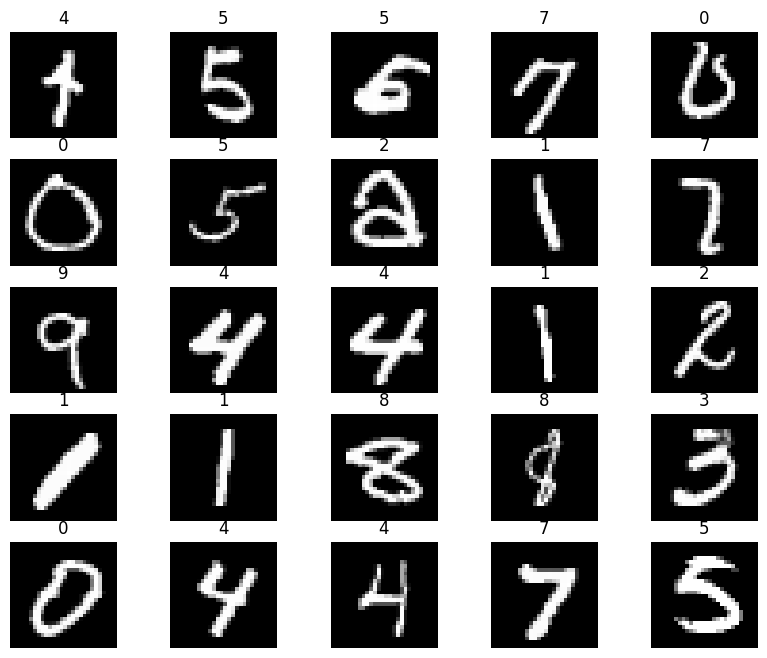

In [ ]:
#Visualize multiple train data
figure = plt.figure(figsize=(10,8))
cols,rows=5,5
for i in range(1,cols*rows+1):
  sample_idx = torch.randint(len(train_data),size=(1,)).item()
  img,label = train_data[sample_idx]
  figure.add_subplot(rows,cols,i)
  plt.title(label)
  plt.axis('off')
  plt.imshow(img.squeeze(),cmap='gray')
plt.show()

In [ ]:
loaders = {'train':DataLoader(train_data,batch_size=100,shuffle=True,num_workers=1),
           'test': DataLoader(test_data,batch_size=100, shuffle=True,num_workers=1)}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f4a5944b2b0>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f4a5944b370>}

In [ ]:
batch_size = 64

# Load the pretrained Swin Transformer model
weights = Swin_T_Weights.DEFAULT
model = swin_t(weights=weights)
#pretrained_model = swin_t(pretrained=True)

# Modify the head of the model for MNIST classification
# Create a new Conv2d layer with modified parameters to match the grayscale images
new_conv = nn.Conv2d(1, 96, kernel_size=(4, 4), stride=(4, 4))
# Replace the first Conv2d layer in the features with the new Conv2d layer
model.features[0][0] = new_conv

model.head = nn.Linear(model.head.in_features, 10)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def train(num_epochs, model, loaders):
    model.train()
    total_step = len(loaders['train'])
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)
            loss = criterion(output, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}")

train(num_epochs, model, loaders)



Downloading: "https://download.pytorch.org/models/swin_t-704ceda3.pth" to /root/.cache/torch/hub/checkpoints/swin_t-704ceda3.pth
100%|██████████| 108M/108M [00:01<00:00, 62.1MB/s] 


Epoch [1/10], Step [100/600], Loss: 1.2594
Epoch [1/10], Step [200/600], Loss: 0.4506
Epoch [1/10], Step [300/600], Loss: 0.1948
Epoch [1/10], Step [400/600], Loss: 0.3127
Epoch [1/10], Step [500/600], Loss: 0.1213
Epoch [1/10], Step [600/600], Loss: 0.0819
Epoch [2/10], Step [100/600], Loss: 0.1613
Epoch [2/10], Step [200/600], Loss: 0.0739
Epoch [2/10], Step [300/600], Loss: 0.0947
Epoch [2/10], Step [400/600], Loss: 0.0259
Epoch [2/10], Step [500/600], Loss: 0.1603
Epoch [2/10], Step [600/600], Loss: 0.1236
Epoch [3/10], Step [100/600], Loss: 0.2138


In [ ]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in loaders['test']:
        images = images.to(device)
        labels = labels.to(device)

        output = model(images)
        _, predicted = torch.max(output.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"Test Accuracy: {accuracy * 100:.2f}%")